In [1]:
from matplotlib import pyplot as plt
import numpy as np
import math
from scipy import constants as sc
import numpy, scipy.optimize
from scipy.optimize import curve_fit
from scipy import ndimage
import matplotlib.patches as patches
import cv2
import abel
import os
import glob
from os.path import exists
from scipy.signal import savgol_filter

def save_data_to_txt(x_data, y_data, file_path, header=('X', 'Y')):
    # Stack x and y data as columns
    data = np.column_stack((x_data, y_data))
    # Save data to a text file with a header
    np.savetxt(file_path, data, header='\t'.join(header), comments='')

def crop_and_rotate_image(image, xmin, xmax, ymin, ymax, angle):
    # Crop the image
    cropped_image = image[ymin:ymax, xmin:xmax]
    # Rotate the cropped image
    rotated_image = ndimage.rotate(cropped_image, angle, reshape=False)
    return rotated_image

def splice_middle_elements(lst, N):
    is_odd = len(lst) % 2 != 0 # Check if the list has an even or odd number of elements
    start_index = len(lst) // 2 - N // 2 # Calculate the starting index for splicing
    if is_odd: # Adjust the start index for odd-sized lists
        start_index += 1
    spliced_elements = lst[start_index:start_index + N] # Splice the middle N elements
    return spliced_elements

def pyAbelTransform(PhaseMap, plumeOrientation):

    # If inverting the full, symmetric Gaussian, pyAbel requires that nrows is odd.
    if PhaseMap.shape[0] % 2 == 0:
        # Add one more row of zeros at the edge.
        PhaseMap = np.append(PhaseMap, np.zeros((1, PhaseMap.shape[1])), axis=0);
    (nrows, ncolumns) = PhaseMap.shape;

    # pyAbel assumes symmetry around vertical axis; if the plume is oriented horizontally, the phase image needs to be transposed first
    if 'horizontal' in plumeOrientation:
        PhaseMap = np.transpose(PhaseMap)

    AbelInvertedPhase = abel.Transform(PhaseMap,
                                    direction='inverse', #transform performed from 2D projection to cylindrical coords
                                    method='hansenlaw',
                                    origin='image_center',
                                    symmetrize_method='average',
                                    symmetry_axis=0,
                                    ).transform;

    if 'horizontal' in plumeOrientation:
        AbelInvertedPhase = np.transpose(AbelInvertedPhase);
    
    return AbelInvertedPhase;


def change_ticks(data=object,pixsize=float,axis=object,change_X=bool,change_Y=bool):
    (nrows,ncols)=data.shape
    N_x=math.floor(ncols*pixsize/100) #max integer number of hundreds of microns that fit into the horizontal axis
    N_y=math.floor(nrows*pixsize/100) #max integer number of hundreds of microns that fit into the vertical axis
    new_xticks=np.around(np.linspace(0,N_x*100,N_x+1),decimals=0) #generate a list of integer ticks for the horizontal axis
    new_xticks = [int(x) for x in new_xticks]
    new_yticks=np.around(np.linspace(0,N_y*100,N_y+1),decimals=0) #generate a list of integer ticks for the vertical axis
    new_yticks = [int(x) for x in new_yticks]
    #find horizontal locations (in pixels) corresponding to the desired tick locations (given in mm), rounded to the nearest pixel:
    new_xtick_locations = np.around(np.array(new_xticks)/pixsize,decimals=0).astype(int) #also, cast into integers
    #find vertical locations (in pixels) corresponding to the desired tick locations (given in mm), rounded to the nearest pixel:
    new_ytick_locations = np.around(np.array(new_yticks)/pixsize,decimals=0).astype(int) #also, cast into integers
    if change_X:
        axis.set_xticks(new_xtick_locations,new_xticks) #set the horizontal axis ticks
        axis.set_xlabel('X [microns]')
    if change_Y:
        axis.set_yticks(new_ytick_locations,new_yticks) #set the vertical axis ticks
        axis.set_ylabel('Y [microns]')
    return

def analyze_phase_shift(filepath=list, #path to a folder containing 1030nm phase maps
                 wavelength_nm=float, #wavelength of the phase map [nm]
                 weights=list,
                 plot_title=str, #title of the plot (what will be displayed on top of the saved image)
                 dev_angle_override=float, #[deg] automated image leveling can be overrriden by giving an angle by how much the channel in the 1030nm phase map should be rotated
                 roll_override=int, #override the automatic roll of the phase map by a manual value
                 flip_sign=bool, #Flip the sign of the phase map? Electrons should give negative phase!
                 repair_abel=bool,
                 xlims_um=list, #xlims of the ROI (tuple, in microns)
                 ylims_um=list, #ylims of the ROI

                 xlims_bg=list, #xlims of the background region
                 ylims_bg=list, #ylims of the background region
                 pixsize=float #cmarea pixel calibration, microns per pixel
                 ): 

    xmin=int(xlims_um[0]/pixsize) #turn limits from microns to pixels
    xmax=int(xlims_um[1]/pixsize)
    ymin=int(ylims_um[0]/pixsize)
    ymax=int(ylims_um[1]/pixsize)

    xmin_bg=int(xlims_bg[0]/pixsize)
    xmax_bg=int(xlims_bg[1]/pixsize)
    ymin_bg=int(ylims_bg[0]/pixsize)
    ymax_bg=int(ylims_bg[1]/pixsize)

    #flip sign of the avg. phase (if required)
    dats = [] 
    for filename,weight in zip(filepath,weights):
        data = np.loadtxt(filename)
        for i in range(np.abs(weight)):
            if weight>=0:
                dats.append(data)
            else: dats.append(-data)
    
    data = np.mean(dats,axis=0)
    if flip_sign:
            data=-data

    bg_ROI = data[ymin_bg:ymax_bg, xmin_bg:xmax_bg] #crop the background of the phase map
    print('stdev bg ROI: {:.0f} mrad'.format(1000*np.std(bg_ROI)))
    data=data-np.mean(bg_ROI) #subtract the mean of the background from the phase map

    # Assuming data is organized in rows and columns
    rows, cols = data.shape

    # Create a meshgrid for plotting
    X, Y = np.meshgrid(np.arange(cols),np.arange(rows))

    xlen=xmax-xmin #horizontal length of the cropped image portion
    ylen=ymax-ymin #vertical length of the cropped image portion

    xlen_bg=xmax_bg-xmin_bg #horizontal length of the cropped image portion
    ylen_bg=ymax_bg-ymin_bg #vertical length of the cropped image portion

    #create a figure
    fig, ax = plt.subplots(3,3,figsize=(16,12),gridspec_kw={'width_ratios': [4,2,2], 'height_ratios':[2,1,1]})
    plt.subplots_adjust(wspace=0, hspace=0.3) #set spaces between subplots in the figure

    ax[0,0].pcolormesh(X, Y, data, cmap='RdBu',vmin=-0.15,vmax=0.15) #show the phase map
    change_ticks(data=data,pixsize=pixsize,axis=ax[0,0],change_X=True,change_Y=True) #change ticks from pixels to microns
    ax[0,0].set_title('2D phase shift map')
    ax[0,0].axis('equal')
    # Create a rectangle patch for the ROI and background and add it to the phase maps
    rectangle = patches.Rectangle((xmin, ymin), xlen, ylen, linewidth=2, edgecolor='magenta', facecolor='none')
    rectangle_bg = patches.Rectangle((xmin_bg, ymin_bg), xlen_bg, ylen_bg, linewidth=2, edgecolor='black', facecolor='none')
    ax[0,0].add_patch(rectangle)
    ax[0,0].add_patch(rectangle_bg)
    ax[0,0].text(s='ROI before rotation',x=xmin+5,y=ymax+10,color='magenta')
    ax[0,0].text(s='background region',x=xmin_bg+5,y=ymax_bg+10,color='black')

    phaseLine=np.mean(data,axis=1) #make a horizontal projection of the mean phase 

    cropped_image = data[ymin:ymax, xmin:xmax] #crop the ROI of the phase map

    # rotate the ROI via manual override;
    dev_angle = dev_angle_override
    rotated_image = ndimage.rotate(cropped_image, dev_angle, reshape=True)

    ydata = np.mean(rotated_image,axis=1) #take mean of the cropped and rotated phase along the horizontal axis (to get a vertical projection)
    xdata=np.linspace(-len(ydata)/2,len(ydata)/2,len(ydata))*pixsize #create axis for the mean phase (in microns, not pixels)

    # finding a reasonable parameter guesses for a gaussian fit to the mean phase
    n_fit = len(ydata)
    mean_guess = sum(xdata*ydata)/n_fit
    sigma_guess = sum(ydata*(xdata-mean_guess)**2)/n_fit
    A_guess = max(ydata)
    H_guess = np.mean(ydata)

    # Define the Gaussian function
    def gauss(x, H, A, x0, sigma): 
        return H + A * np.exp(-(x - x0) ** 2 / (2 * sigma ** 2))
    #fit a gaussian to the mean cropped phase projection
    params, covariance = curve_fit(gauss, xdata, ydata, p0=[H_guess,A_guess,mean_guess,sigma_guess]);
    
    H, A, x0, sigma = params #extract the params
    
    fit_y = gauss(xdata,H,A,x0,sigma) #generate a fit using the params

    max_ind=np.where(fit_y==min(fit_y))[0][0] #find the location of the peak of the fit
    center_ind = int(len(ydata)/2) #find the index of the center element in the mean phase
    roll_by = max_ind - center_ind #find the number of elements the mean phase map needs to be rolled by for the peak to be centered

    rolled_image=np.roll(rotated_image,-roll_by,axis=0) #roll the phase map ROI so that the phase peak is centered
    rolled_image=np.roll(rolled_image,roll_override,axis=0) #override the roll by a manual value if the automatic roll is not good

    rolled_image = rolled_image - fit_y[-1] #subtract offset from the phase map (found using the gaussian fit)

    phase_projection = np.mean(rolled_image,axis=1) #make a final projection of the phase, after centering the phase map ROI
    params, covariance = curve_fit(gauss, xdata, phase_projection, p0=[H_guess,A_guess,mean_guess,sigma_guess]); #make a new Gaussian fit
    H, A, x0, sigma = params #extract the new params after centering
    fit_y_2 = gauss(xdata,H,A,x0,sigma) #create a new fit (after centering)

    err_to_peak =  np.abs(A)-np.std(bg_ROI) #difference of the STDEV of the background to the amplitude of the signal; RED camera

    rows, cols = rolled_image.shape #make meshgrids for plotting of the cropped, rotated and rolled phase ROI
    X, Y = np.meshgrid(np.arange(cols), np.arange(rows))

    #plot the mean phase projection of the full phase map
    ax[0,1].plot(phaseLine*1000,np.arange(len(phaseLine)),color='black')
    ax[0,1].set_xlabel('mrad')
    ax[0,1].set_title('horizontal projection (mean)')
    ax[0,1].set_yticks([])
    ax[0,1].set_yticklabels([])
    ax[0,1].set_xlim(-140,140)

    #ax[0,1].axvline(-85,color='black',ls='dashed')
    
    ax[1,0].axhline(y=rows/2,color='black',linestyle='dashdot',linewidth=1)
    vlim=np.abs(np.amin(rolled_image))
    ax[1,0].pcolormesh(X, Y, rolled_image, cmap='RdBu',vmin=-vlim,vmax=vlim)
    ax[1,0].axis('equal')
    ax[1,0].set_title('rotated and centered ROI')
    change_ticks(data=rolled_image,pixsize=pixsize,axis=ax[1,0],change_X=True,change_Y=True)

    ax[1,1].plot(fit_y_2*1000, xdata, label='gauss fit',color='black',linewidth=1)
    ax[1,1].plot(phase_projection*1000,xdata,label='data')
    ax[1,1].axhline(y=0,color='black',linestyle='dashdot',linewidth=1)
    ax[1,1].set_xlim(1.1*min(phase_projection*1000),20)
    ax[1,1].set_xlabel('[mrad]')
    ax[1,1].set_ylabel(r'r [$\mu$m]')
    ax[1,1].set_title('mean phase shift (projection)')
    ax[1,2].yaxis.tick_right()
    ax[1,2].yaxis.set_label_position("right")
    ax[1,1].legend()

    lambda_m=wavelength_nm*1e-9 #RED wavelength [m]
    Delta_lambda_m = 10e-9 #uncertainty in the RED wavelength - taking the bandwidth...?

    #abel-invert the centered and rotated phase map ROI
    abel_transformed_phase = pyAbelTransform(PhaseMap=rolled_image, plumeOrientation='horizontal')

    #plot the abel-inverted phase map, and change the ticks to microns
    ax[2,0].imshow(abel_transformed_phase,cmap='RdBu',vmin=np.amin(abel_transformed_phase),vmax=-np.amin(abel_transformed_phase))
    ax[2,0].set_title('Abel-inverted phase shift')
    change_ticks(data=abel_transformed_phase,pixsize=pixsize,axis=ax[2,0],change_X=True,change_Y=True)

    N = 200 #number of elements to be considered for a centered projection of the Abel-inverted phase
    N_size = len(np.mean(abel_transformed_phase,axis=1)) #actual length of the projection
    xabel = splice_middle_elements(np.linspace(-N_size/2,N_size/2,N_size)*pixsize, N) #x-axis for the centered projection, in microns

    #get the centered and cropped projection of the perturbation in refractive index (abel inversion of the phase map *factor)
    yabel = splice_middle_elements(np.mean(pyAbelTransform(PhaseMap=rolled_image*lambda_m/(2*np.pi*pixsize*1e-6), plumeOrientation='horizontal'),axis=1), N)
    
    #get the stdev of the same thing
    yabel_stdev = splice_middle_elements(np.std(pyAbelTransform(PhaseMap=rolled_image*lambda_m/(2*np.pi*pixsize*1e-6), plumeOrientation='horizontal'),axis=1), N)

    #plot the perturbation in index of refraction
    ax[2,1].plot(xabel,1000*yabel,color='red',label='1030 nm')

    #plot the stdev (error)
    ax[2,1].fill_between(xabel,1000*(yabel+1/2*savgol_filter(yabel_stdev,15,2)),1000*(yabel-1/2*savgol_filter(yabel_stdev,15,2)),color='red',alpha=0.5,linewidth=0)

    ax[2,1].set_ylabel(r'$\Delta \eta$(r) [10$^{-3}$]')
    ax[2,1].set_xlabel(r'r [$\mu$m]')
    ax[2,1].legend()
    ax[2,1].set_title('Abel-inverted refractive\nindex perturbation')
    ax[2,2].set_title('Eletron density $N_e$[cm$^{-3}$]')
    ax[2,1].set_xlim(-100,100)
    ax[2,1].set_ylim(1.1*1000*min(yabel),0.05)

    #the following is an electron extractio;n from the refractive index perturbation
    #get the centered and cropped perturbation in refractive index (abel inversion of the phase map *factor)
    #this time not a projection but an actual 2D map!
    A_2D = pyAbelTransform(PhaseMap=rolled_image*lambda_m/(2*np.pi*pixsize*1e-6), plumeOrientation='horizontal');
    A = splice_middle_elements(np.mean(A_2D,axis=1),N) #mean of the 2D map, cropped to N elements
    B = -sc.e**2/(8*np.pi**2*sc.epsilon_0*sc.m_e*sc.c**2)*lambda_m**2

    Ne_r = (A/B)*1e-6 #electron density in cm^-3
    
    if repair_abel: #
        Ne_r = savgol_filter(Ne_r,15,2)

    #plot the radial electron density, with error
    ax[2,2].plot(xabel,Ne_r,color='tab:orange',label=r'$N_e(r)$')
    ax[2,2].set_ylabel(r'[cm$^{-3}$]')
    ax[2,2].legend()
    ax[2,2].set_xlabel(r'r [$\mu$m]')

    plt.figtext(0.5, 0.91, plot_title, ha='center', va='center',size=16)

    results = {"sigma": sigma,
               "xabel": xabel,
               "Ne_r":  Ne_r,
               "ROI_phase": rolled_image,
               "abel-inverted_phase_map": abel_transformed_phase,
               "d_eta_r": yabel, #refractive index perturbation (found after abel-inverting stuff)
               "phase_projection": phase_projection, #projection of the phase map after centering
               "A": A,
               "B": B,
               "err_to_peak": err_to_peak,
               "sigma":sigma
               }

    return results

In [19]:
common_path = r'C:\Users\kalos\Documents\kPAC\ChannelAnalysis_CALA_Sept25\channel_analysis_250917_timescan\phase_maps'

IR_100mbar_t1p0ns_Bdel582  = [common_path+r"100mbar_Bdel582_t1.0ns\Interferometry2\AvgPhase.txt"]
IR_100mbar_t2p0ns_Bdel582  = [common_path+r"100mbar_Bdel582_t2.0ns\Interferometry2\AvgPhase.txt"]
IR_100mbar_t2p5ns_Bdel582  = [common_path+r"100mbar_Bdel582_t2.5ns\Interferometry2\AvgPhase.txt"]
IR_100mbar_t3p0ns_Bdel582  = [common_path+r"100mbar_Bdel582_t3.0ns\Interferometry2\AvgPhase.txt"]
IR_100mbar_t3p5ns_Bdel582  = [common_path+r"100mbar_Bdel582_t3.5ns\Interferometry2\AvgPhase.txt"]
IR_100mbar_t4p0ns_Bdel582  = [common_path+r"100mbar_Bdel582_t4.0ns\Interferometry2\AvgPhase.txt"]

stdev bg ROI: 5 mrad


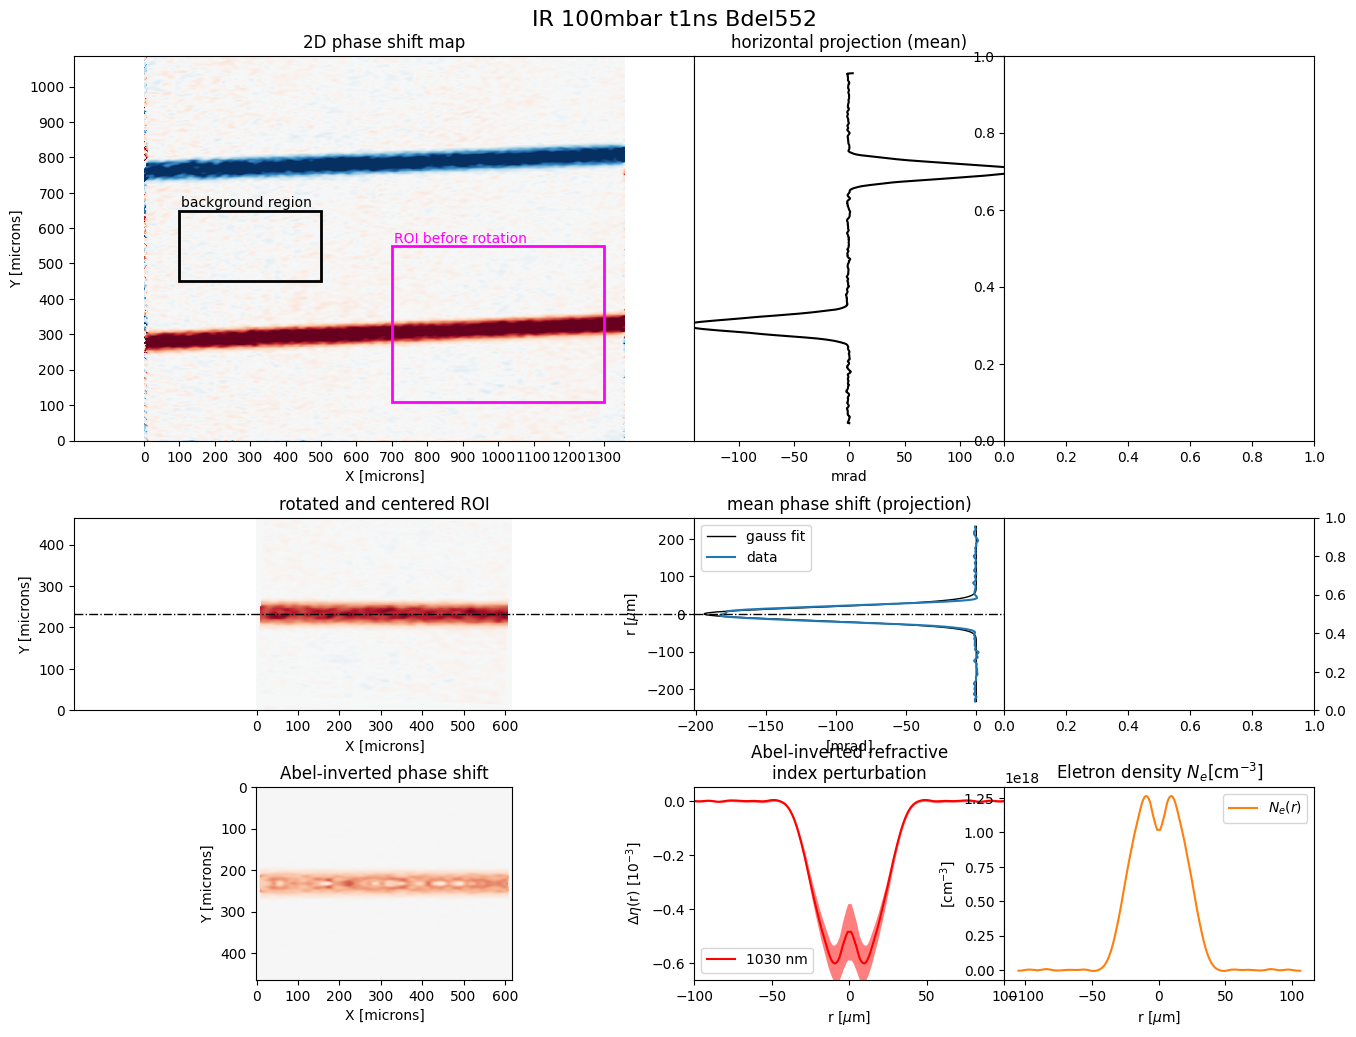

In [16]:
res_IR_100mbar_t1p0_Bdel582=analyze_phase_shift( 
                        filepath=IR_100mbar_t1p0ns_Bdel582,
                        wavelength_nm=1030,
                        weights=[1],
                        plot_title=r"IR 100mbar t1ns Bdel552", 
                        dev_angle_override=2.5,
                        roll_override=0,
                        flip_sign=True,
                        repair_abel=False,
                        xlims_um=[700,1300],
                        ylims_um=[110,550],
                        xlims_bg=[100,500],
                        ylims_bg=[450,650],
                        pixsize=1.06 #camera pixel calibration [um/pixel]
                        )

stdev bg ROI: 4 mrad


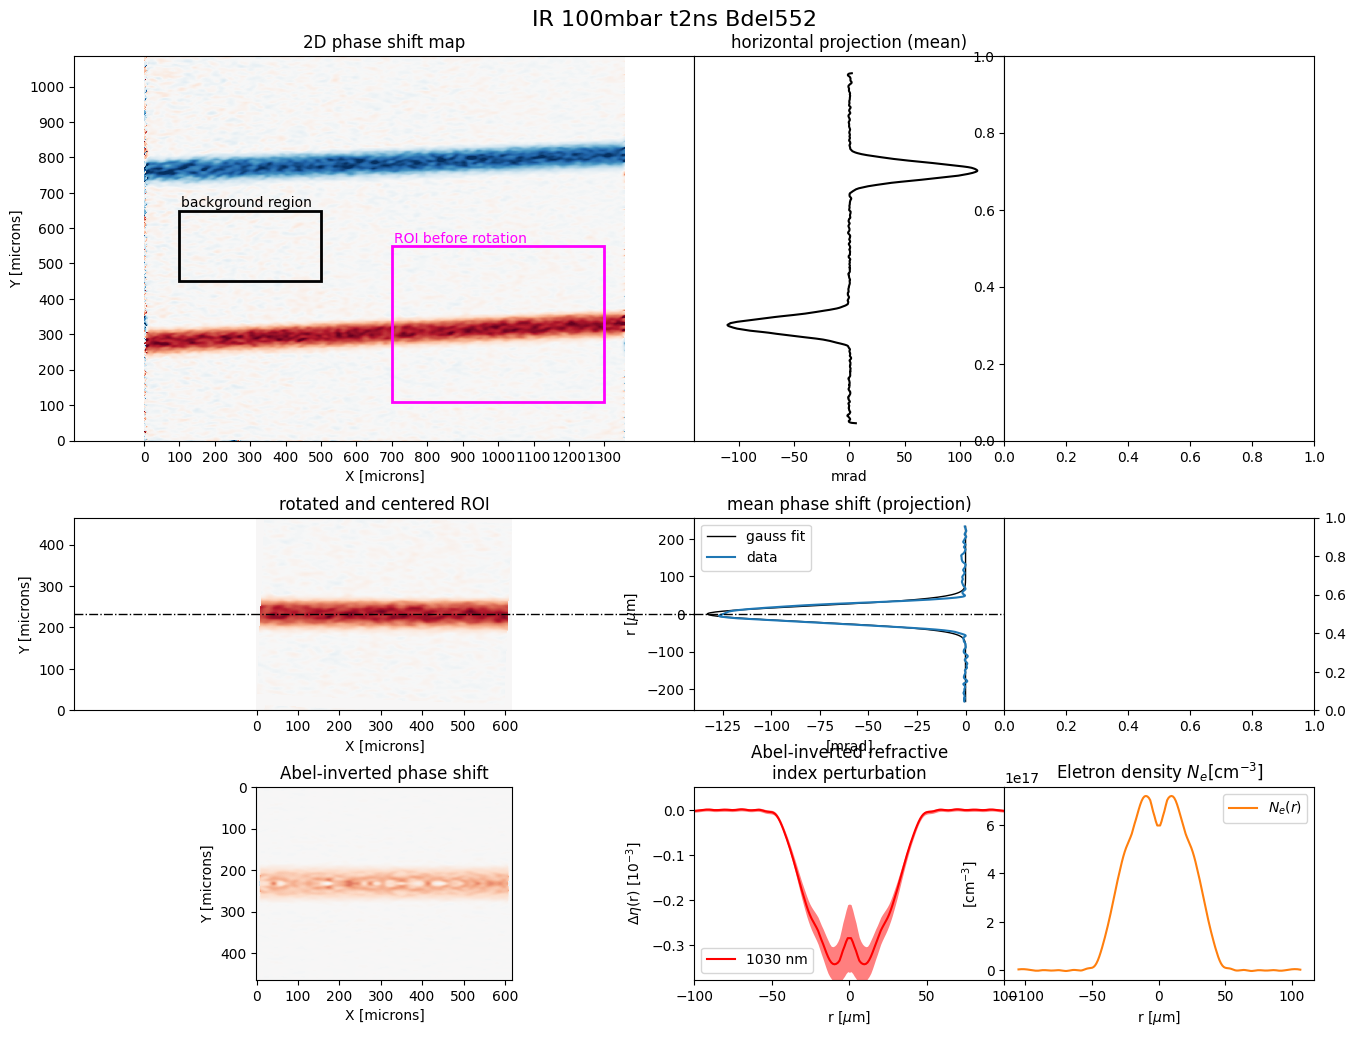

In [17]:
res_IR_100mbar_t2p0_Bdel582=analyze_phase_shift( 
                        filepath=IR_100mbar_t2p0ns_Bdel582,
                        wavelength_nm=1030,
                        weights=[1],
                        plot_title=r"IR 100mbar t2ns Bdel552", 
                        dev_angle_override=2.5,
                        roll_override=0,
                        flip_sign=True,
                        repair_abel=False,
                        xlims_um=[700,1300],
                        ylims_um=[110,550],
                        xlims_bg=[100,500],
                        ylims_bg=[450,650],
                        pixsize=1.06 #camera pixel calibration [um/pixel]
                        )

stdev bg ROI: 3 mrad


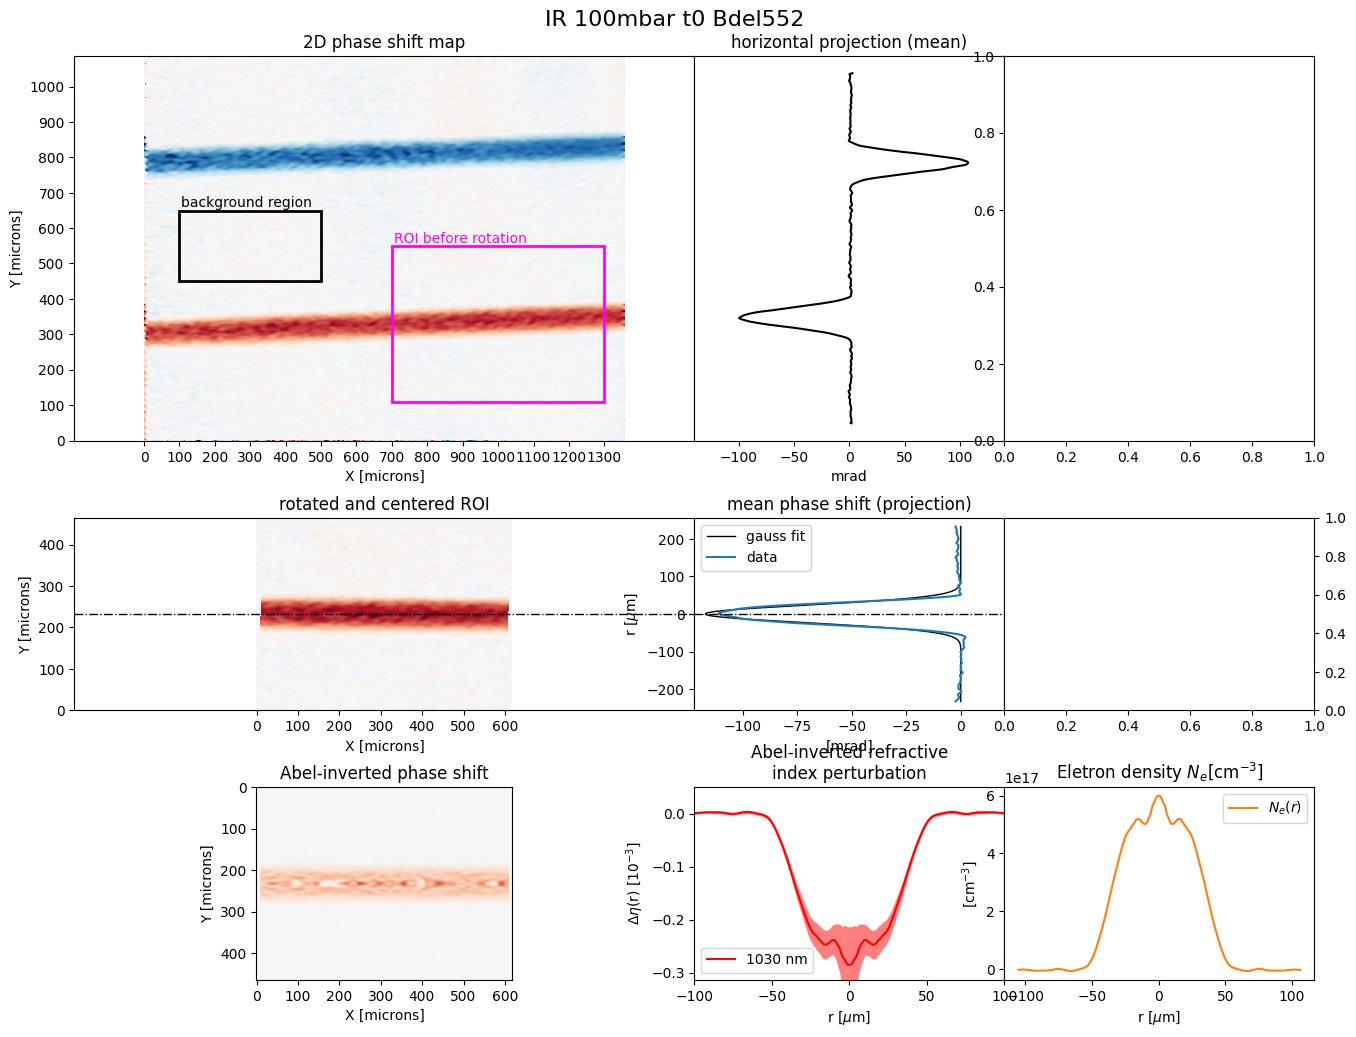

In [14]:
res_IR_100mbar_t2p5_Bdel582=analyze_phase_shift( 
                        filepath=IR_100mbar_t2p5ns_Bdel582,
                        wavelength_nm=1030,
                        weights=[1],
                        plot_title=r"IR 100mbar t0 Bdel552", 
                        dev_angle_override=2.5,
                        roll_override=0,
                        flip_sign=True,
                        repair_abel=False,
                        xlims_um=[700,1300],
                        ylims_um=[110,550],
                        xlims_bg=[100,500],
                        ylims_bg=[450,650],
                        pixsize=1.06 #camera pixel calibration [um/pixel]
                        )

stdev bg ROI: 4 mrad


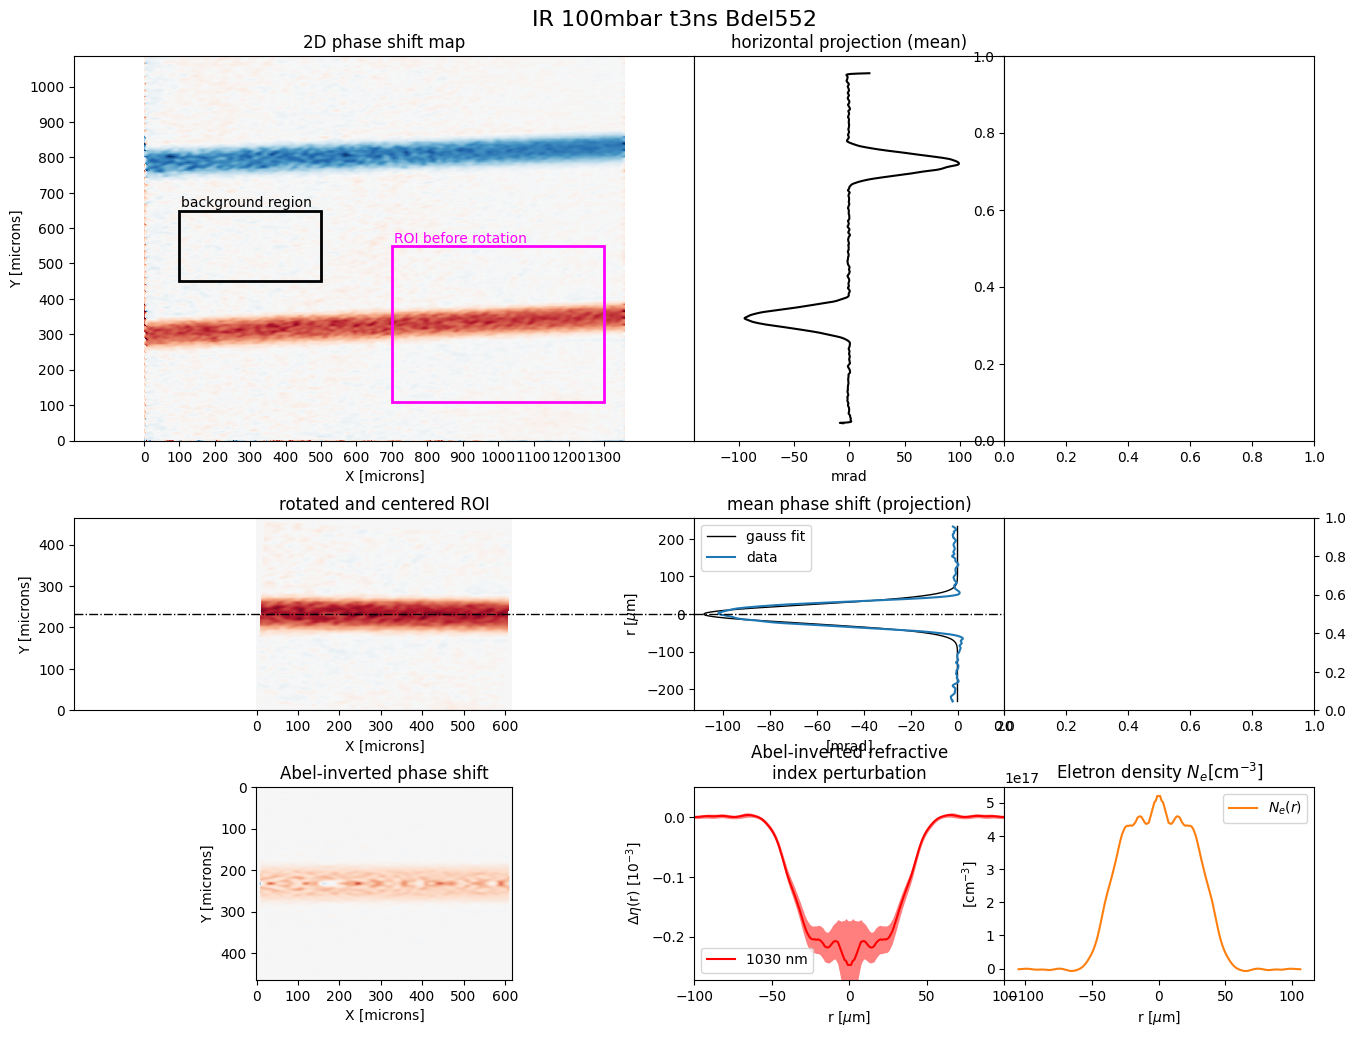

In [20]:
res_IR_100mbar_t3p0_Bdel582=analyze_phase_shift( 
                        filepath=IR_100mbar_t3p0ns_Bdel582,
                        wavelength_nm=1030,
                        weights=[1],
                        plot_title=r"IR 100mbar t3ns Bdel552", 
                        dev_angle_override=2.5,
                        roll_override=0,
                        flip_sign=True,
                        repair_abel=False,
                        xlims_um=[700,1300],
                        ylims_um=[110,550],
                        xlims_bg=[100,500],
                        ylims_bg=[450,650],
                        pixsize=1.06 #camera pixel calibration [um/pixel]
                        )

stdev bg ROI: 4 mrad


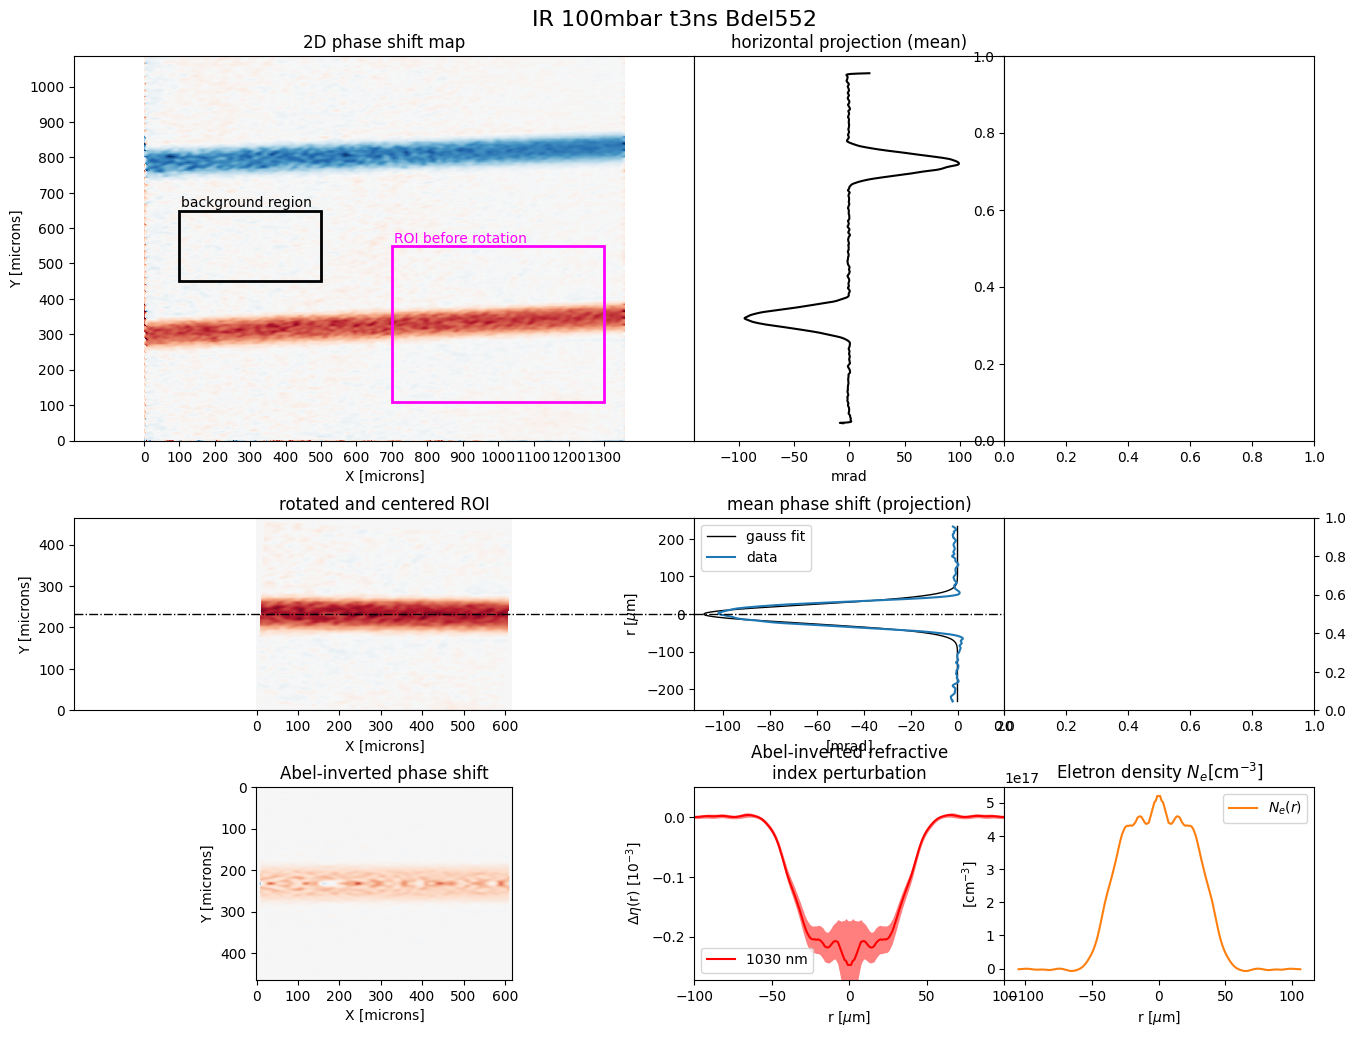

In [21]:
res_IR_100mbar_t3p0_Bdel582=analyze_phase_shift( 
                        filepath=IR_100mbar_t3p0ns_Bdel582,
                        wavelength_nm=1030,
                        weights=[1],
                        plot_title=r"IR 100mbar t3ns Bdel552", 
                        dev_angle_override=2.5,
                        roll_override=0,
                        flip_sign=True,
                        repair_abel=False,
                        xlims_um=[700,1300],
                        ylims_um=[110,550],
                        xlims_bg=[100,500],
                        ylims_bg=[450,650],
                        pixsize=1.06 #camera pixel calibration [um/pixel]
                        )

stdev bg ROI: 5 mrad


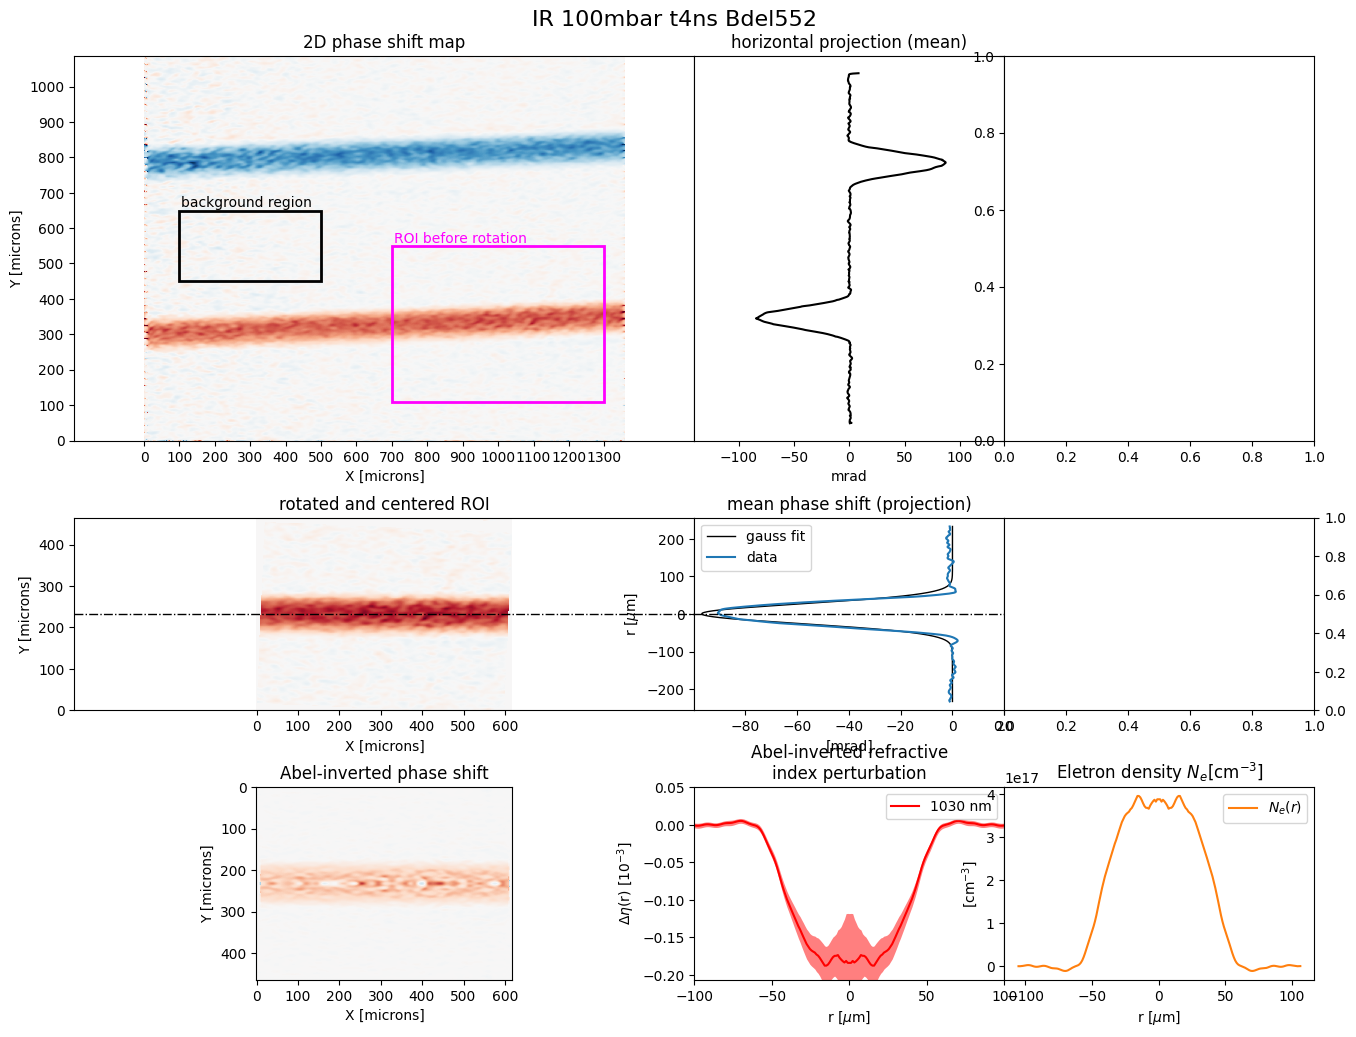

In [22]:
res_IR_100mbar_t4p0_Bdel582=analyze_phase_shift( 
                        filepath=IR_100mbar_t4p0ns_Bdel582,
                        wavelength_nm=1030,
                        weights=[1],
                        plot_title=r"IR 100mbar t4ns Bdel552", 
                        dev_angle_override=2.5,
                        roll_override=0,
                        flip_sign=True,
                        repair_abel=False,
                        xlims_um=[700,1300],
                        ylims_um=[110,550],
                        xlims_bg=[100,500],
                        ylims_bg=[450,650],
                        pixsize=1.06 #camera pixel calibration [um/pixel]
                        )

(0.0, 80.0)

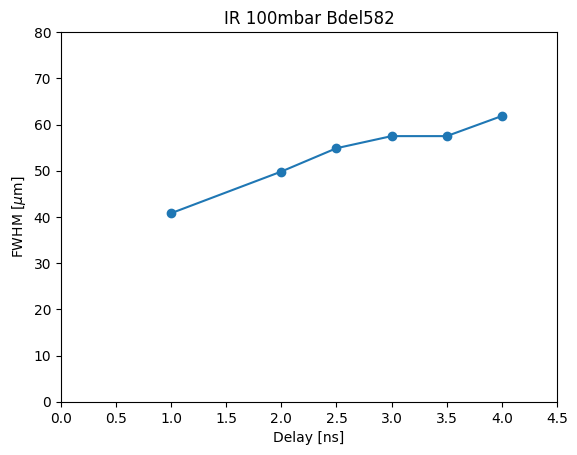

In [26]:
fwhm_list = []
for res in [res_IR_100mbar_t1p0_Bdel582,
            res_IR_100mbar_t2p0_Bdel582,
            res_IR_100mbar_t2p5_Bdel582,
            res_IR_100mbar_t3p0_Bdel582,
            res_IR_100mbar_t3p0_Bdel582,
            res_IR_100mbar_t4p0_Bdel582]:
    fwhm = 2*res['sigma']*np.sqrt(2*np.log(2))
    fwhm_list.append(np.abs(fwhm))
plt.plot([1.0,2.0,2.5,3.0,3.5,4.0],fwhm_list,'o-')
plt.xlabel('Delay [ns]')
plt.ylabel('FWHM [$\mu$m]')
plt.title('IR 100mbar Bdel582')
plt.xlim(0,4.5)
plt.ylim(0,80)